## [Master en Data Science (UC-UIMP)] Introduction to R
### Practise: Building a weather generator
### Using R or Python (or both). Indicative examples provided in R

#### Introduction

Weather generators are computational models which generate (daily) synthetic series of random values simulating the distribution of a particular meteorological variable. Precipitation is the most popular example due to its mixed character: discrete (ocurrence: dry or wet) and continuous (rain amount for wet days). The discrete part is typically characterized by the frequency of wet/dry days (say, e.g. 0.53/0.47 in Santander), whereas the continuous is typically characterized by an exponential distribution defined by a rate parameter (you don't need to understand statistics for this practise! it is only about programming).

In this practice we will use the main control structures (conditionals and loops) and apply them to build a simple weather generator and create artificial precipitation amount series. To this aim we will use some functions which simulate (pseudo)random numbers from different families of distributions (uniform and exponential), which is a key task for several computational statistics problems (you will learn a lot more about this in the stastistics course).

## How does a precipitation time series look like?

In order to work with real data, we will use to files with daily information for two weather stations: Santander CMT (RR_STAID003922.txt) and Santander/Parayas (RR_STAID003923.txt). The former is located in the Santander regional center (close to el Faro de Cabo Mayor) and the latter is located in Santander airpot. Open one of the files with a text editor and see the structure: it has some lines with information (to be skipped) and then a header followed by number in columns (STAID: the code of the station; SOUI: the international code of the station; DATA: the day; RR: precipitation value; Q_RR: a quality control flat, 0: OK; 9: missing data).

In [1]:
# Loading libraries
library(ggplot2)

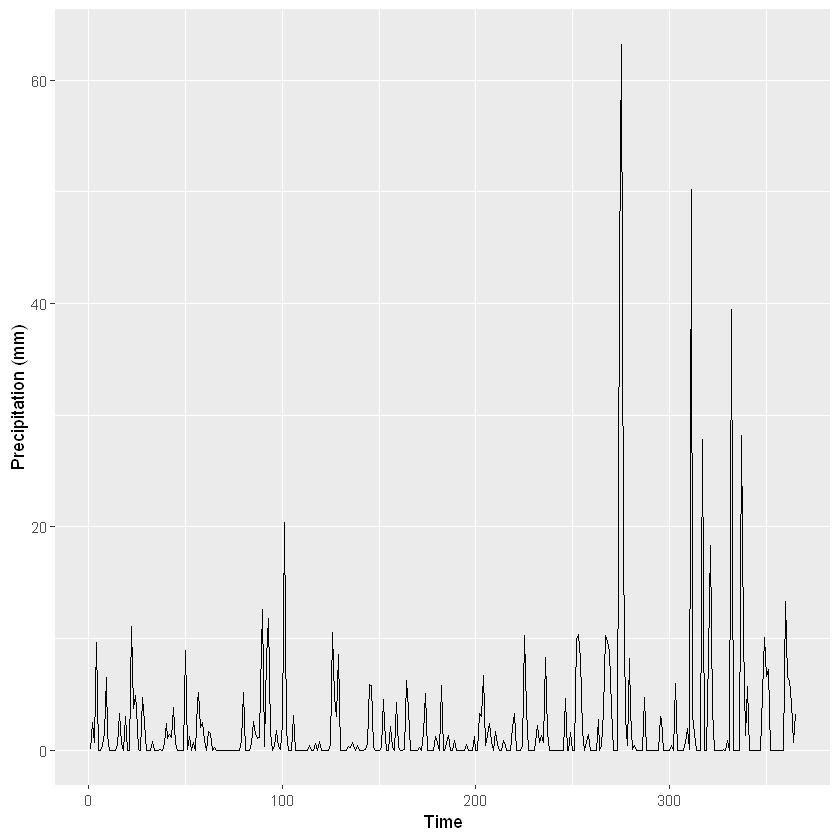

In [2]:
# Loading and ploting data for Santander CMT
precipCMT <- read.csv("Data/RR_STAID003922.txt", skip = 20, header = T)
precipCMT$RR <-precipCMT$RR / 10 # To mm
ggplot() +  # first year
    geom_line(aes(x = 1:365, y = precipCMT$RR[1:365])) +
    xlab('Time') + ylab('Precipitation (mm)')

Now try to load the data for Parayas (in this case the series contains missing data characterized by -9999, you will see this when plotting). In both cases, the units of the data is "10*mm". You need to divide both series by 10 in order to get "mm" (litros por metro cuadrado). 

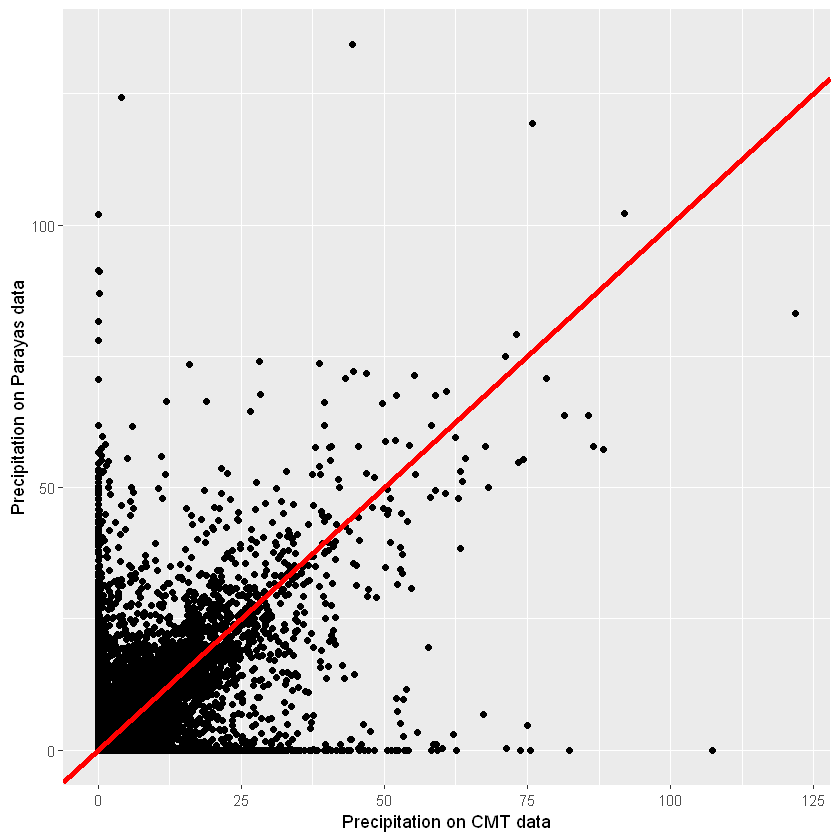

In [4]:
# Load the series for Parayas and remove missing data.
# Both series should be very similar. Compare them using e.g. 
# a scatter plot (points displayed along the diagonal if equal).

precipParayas <- read.csv("Data/RR_STAID003923.txt", skip = 20, header = T)
precipParayas <- precipParayas[precipParayas$Q_RR != 9, ]
precipParayas$RR <- precipParayas$RR / 10 # To mm

auxDF <- data.frame(CMR = tail(precipCMT$RR, nrow(precipParayas)),
                    Parayas = precipParayas$RR)
ggplot(auxDF) + geom_point(aes(x = CMR, y = Parayas)) +
    geom_abline(intercept = 0, slope = 1, colour = 'red', size = 1.5) +
    xlab('Precipitation on CMT data') + ylab('Precipitation on Parayas data')

In [5]:
# Compute basic statistics for both series:
# Frequency of wet days (this is the probability of rain)
probCMT <- sum(precipCMT$RR > 0) / nrow(precipCMT)
probParayas <- sum(precipParayas$RR > 0) / nrow(precipParayas)
finalProb <- mean(c(probCMT, probParayas))

paste('Rain probability on CMT data:', probCMT)
paste('Rain probability on Parayas data:', probParayas)
paste('Mean of both probabilities:', finalProb)

[1] "Rain probability on CMT data: 0.464768184868555"

[1] "Rain probability on Parayas data: 0.445343950453439"

[1] "Mean of both probabilities: 0.455056067660997"

In [5]:
# Transition probabilities (from dry to dry and from dry to wet)
# you may need to create a loop and using a conditional for this

I could simplify some calculations and conditions in the below loops given that $P(Dry\,|\,Dry) + P(Wet\,|\,Dry) = 1$. I decided not do it because it has not a significant optimization effect and the code would be less readable. (I will do it in the final function containing all the process).

In [6]:
# Transition probabilities for CMT
transCMT <- as.integer(precipCMT$RR > 0) # 1 Wet   0 Dry
transVec_CMT <- c(0, 0, 0, 0)
names(transVec_CMT) <- c('Dry|Dry', 'Wet|Dry', 'Dry|Wet', 'Wet|Wet') # P(X_t | X_(t-1))

# Dry based (Dry|Dry, Wet|Dry)
n <- 0
for(i in 2:length(transCMT)) {
  
  if(transCMT[i - 1] == 0 & transCMT[i] == 0) {
    
    transVec_CMT['Dry|Dry'] <- transVec_CMT['Dry|Dry'] + 1
    n <- n + 1
    
  } else if (transCMT[i - 1] == 0 & transCMT[i] == 1) {
    
    transVec_CMT['Wet|Dry'] <- transVec_CMT['Wet|Dry'] + 1
    n <- n + 1
  }
  
}

transVec_CMT[c(1, 2)] <- transVec_CMT[c(1, 2)] / n

# Wet based (Dry|Wet, Wet|Wet)
n <- 0
for(i in 2:length(transCMT)) {
  
  if(transCMT[i - 1] == 1 & transCMT[i] == 0) {
    
    transVec_CMT['Dry|Wet'] <- transVec_CMT['Dry|Wet'] + 1
    n <- n + 1
    
  } else if (transCMT[i - 1] == 1 & transCMT[i] == 1) {
    
    transVec_CMT['Wet|Wet'] <- transVec_CMT['Wet|Wet'] + 1
    n <- n + 1
  }
  
}

transVec_CMT[c(3, 4)] <- transVec_CMT[c(3, 4)] / n

In [7]:
# Transition probabilities for Parayas
transVec_Parayas <- c(0, 0, 0, 0)
transParayas <- as.integer(precipParayas$RR > 0) # 1 Wet   0 Dry
names(transVec_Parayas) <- c('Dry|Dry', 'Wet|Dry', 'Dry|Wet', 'Wet|Wet')

# Dry based (Dry|Dry, Wet|Dry)
n <- 0
for(i in 2:length(transParayas)) {
  
  if(transParayas[i - 1] == 0 & transParayas[i] == 0) {
    
    transVec_Parayas['Dry|Dry'] <- transVec_Parayas['Dry|Dry'] + 1
    n <- n + 1
    
  } else if (transParayas[i - 1] == 0 & transParayas[i] == 1) {
    
    transVec_Parayas['Wet|Dry'] <- transVec_Parayas['Wet|Dry'] + 1
    n <- n + 1
  }
  
}

transVec_Parayas[c(1, 2)] <- transVec_Parayas[c(1, 2)] / n

# Wet based (Dry|Wet, Wet|Wet)
n <- 0
for(i in 2:length(transParayas)) {
  
  if(transParayas[i - 1] == 1 & transParayas[i] == 0) {
    
    transVec_Parayas['Dry|Wet'] <- transVec_Parayas['Dry|Wet'] + 1
    n <- n + 1
    
  } else if (transParayas[i - 1] == 1 & transParayas[i] == 1) {
    
    transVec_Parayas['Wet|Wet'] <- transVec_Parayas['Wet|Wet'] + 1
    n <- n + 1
  }
  
}

transVec_Parayas[c(3, 4)] <- transVec_Parayas[c(3, 4)] / n

In [8]:
# Transitions for CMT
transVec_CMT

Dry|Dry   Wet|Dry   Dry|Wet   Wet|Wet 
0.7035927 0.2964073 0.3413899 0.6586101

In [9]:
# Transitions for Parayas
transVec_Parayas

Dry|Dry   Wet|Dry   Dry|Wet   Wet|Wet 
0.7115737 0.2884263 0.3591934 0.6408066

We can see that both transition matrices are similar, we will work with the one generated by the CMT data due to its higher amount of data

## Generating precipitation occurrence (0/1 series)

We first consider the case of precipitation occurrence (o for dry days and 1 for wet days).  

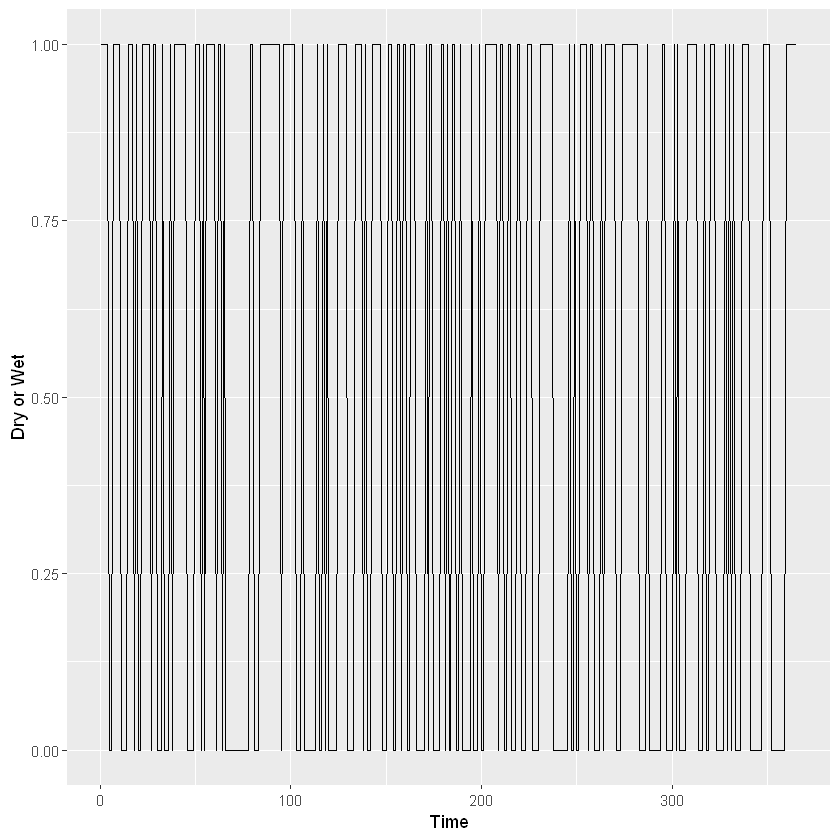

In [10]:
ocurrence <- as.integer(precipCMT$RR > 0)
ggplot() +  # first year
    geom_line(aes(x = 1:365, y = ocurrence[1:365])) +
    xlab('Time') + ylab('Dry or Wet')   

In order to generate a synthetic precipitation series for Santander we can use the function `runif` which generates random uniform numbers (between 0 and 1, which can be viewed as probabilities). Then, random numbers above the rain frequency for Santander can be coverted to one and numbers below to zero. 

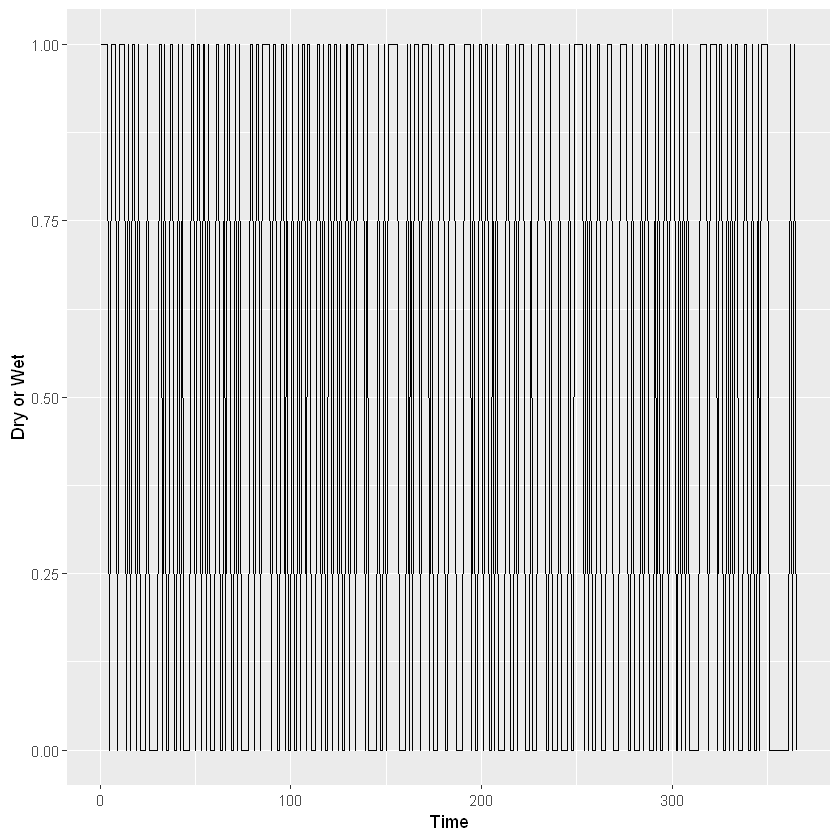

In [11]:
# Obtain a series of 365 uniform numbers (between 0 and 1). 
# Use the frequency tresholds for Santander to convert to 0 or 1 values

simuProbs <- runif(nrow(precipParayas), 0, 1)
simuProbs <- ifelse(simuProbs < finalProb, 1, 0)
ggplot() +  # first year
    geom_line(aes(x = 1:365, y = simuProbs[1:365])) +
    xlab('Time') + ylab('Dry or Wet')

The series does not resemble the real one very much, since real precipitation is autocorrelated (sequences of zeros/ones), whereas the random numbers are not. Therefore, modify the code using the transition probabilities to generate rain ocurrence considering the transition probabilities. You may need to use a loop for this, computing ocurrence[i+1] based on the value of ocurrence[i].

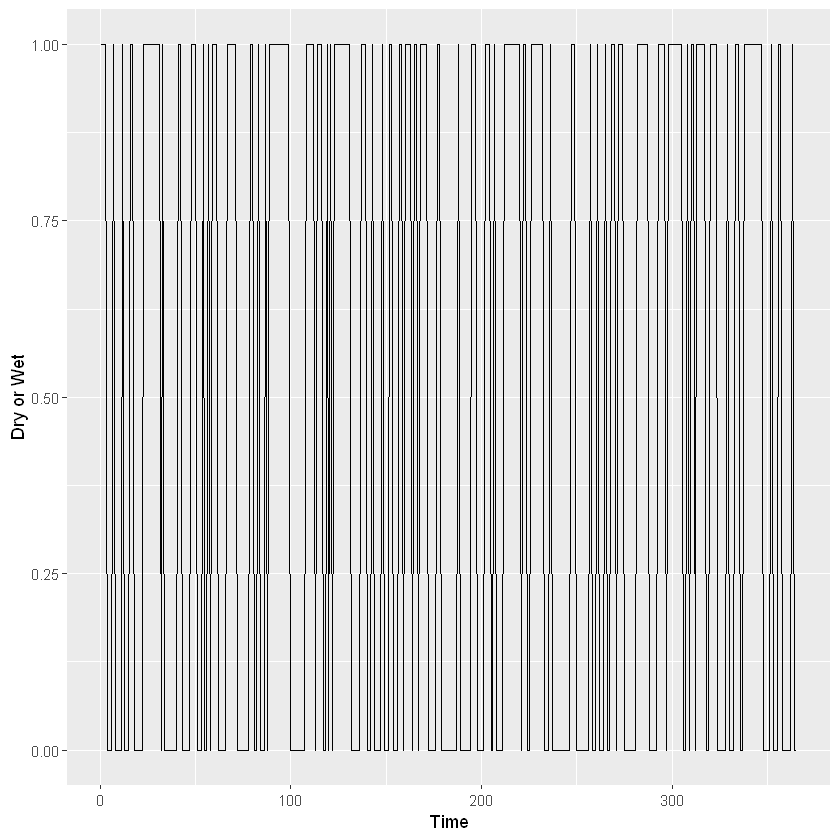

In [12]:
# define a function with arguments for the transition probabilities
# and the number of simulated days and output the simulated series
# insert your code here
simulateData <- function(days, transProb = transVec_CMT) {
  
  outData <- c(round(runif(1, 0, 1))) # First observation
  
  for(i in 2:days) {
    
    outData <- c(outData, runif(1, 0, 1))
    
    if(outData[i - 1] == 0) {
      
      outData[i] <- ifelse(outData[i] < transProb['Dry|Dry'], 0, 1)
      
    } else { # outData[i - 1] == 1
      
      outData[i] <- ifelse(outData[i] < transProb['Dry|Wet'], 0, 1)
      
    }
    
  }
  
  return(outData)
  
}

# plot the result (for a year)
outSample <- simulateData(days = 365)
ggplot() +  
    geom_line(aes(x = 1:length(outSample), y = outSample)) +
    xlab('Time') + ylab('Dry or Wet')

Could you think of a more efficient way of implementing the above function?. Thy to avoid the use of loops by means of vectorized operations.

In [13]:
# vectorized implementation

The for used in the previous function is necessary due to its recursive nature. It is not possible to made a
function with the same functionality without using that for loop. Vectorization is not possible given that the generation of  a value depends on the previous one (and before this generation we have not values at all)

(I tried to vectorize the above code with functions like mapply but didn't work given that the time of computation was the same, that's why I decided not to include these implementations)

## Simulating precipitation amount

The precipitation amount for the wet days (occurrence > 0) can be simulated using an exponential distribution. We need to fit a theoretical distribution to the observed in order to obtain the `rate` parameter. As an alternative, you can used instead the mean of the wet days precipitation amount (mean of precip values > 0). Then, we can use the `rexp` function to simulate random values with the obtained rate. 

and the precipitation amount for the wet days (occuDry == 0). To this aim, we need to fit a theoretical distribution to the observed data for each station. The two distributions most commonly used to simulate precipitation are the [Gamma](http://en.wikipedia.org/wiki/Gamma_distribution) and [Exponential](http://en.wikipedia.org/wiki/Exponential_distribution) distributions. We should load the library `MASS` and use the `fitdistr` function.

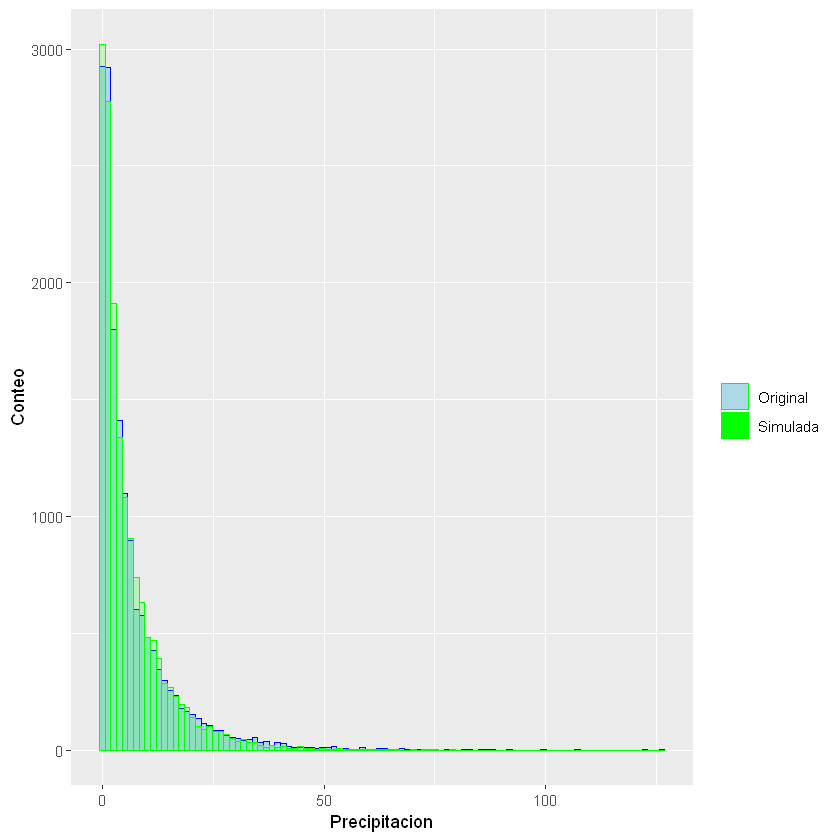

In [13]:
# Option 1: use the library MASS and use the fitdistr function.
library(MASS)   # you may need to install this package
# ? fitdistr      # use fitdistr to fit an exponential and obtain the rate.
# Option 2: estimate the rate as the mean of precip (for days with precip>0 only)
# Use only option 2 if running into trouble with option 1.
RR_MM <- precipCMT$RR[which(precipCMT$RR > 0)] # Here we will use CMT data as reference

fittedGamma <- fitdistr(RR_MM, densfun = 'gamma')
ourShape <- 0.65 # Manually fitted

simGamma <- rgamma(length(RR_MM),
              shape = ourShape,
              rate = fittedGamma$estimate[2])

ggplot() + 
  geom_histogram(aes(RR_MM, fill = 'Original'), bins = 100, colour = 'blue') +
  geom_histogram(aes(simGamma, fill = 'Simulada'), bins = 100, alpha = 0.2, colour = 'green') +
  guides(fill = guide_legend(title = '')) +
  scale_fill_manual(values = c('lightblue', 'green')) +
  xlab('Precipitacion') + ylab('Conteo')

As you can see I have manually tuned the shape parameter $k$ because the simulated distribution did not fit exactly the frequency of the $\sim 0$ values

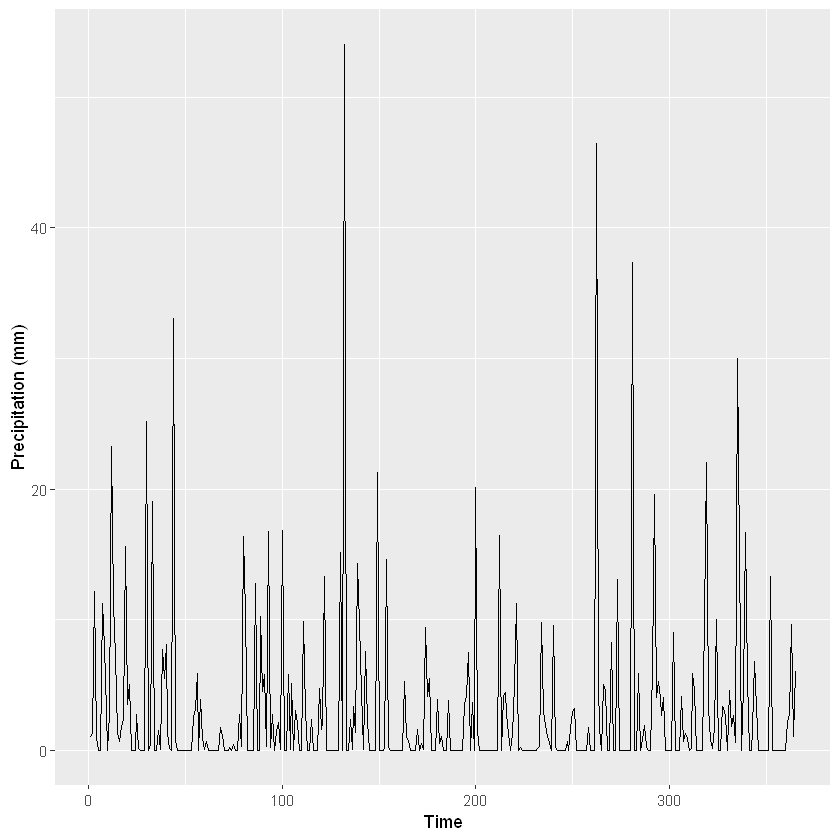

In [14]:
# Using the obtained rate, simulate 365 amount values and obtain the
# precipitation series multiplying the simulated occurrence and amount.

outSample <- simulateData(days = 365, transProb = transVec_CMT)

auxGen <- function(x) {
      x <- rgamma(1,
                  shape = ourShape,
                  rate = fittedGamma$estimate[2])
      return(x)
}

outSample[outSample == 1] <- sapply(outSample[outSample == 1],
                                    auxGen)

ggplot() +  
    geom_line(aes(x = 1:length(outSample), y = outSample)) +
    xlab('Time') + ylab('Precipitation (mm)')

Now, we can gather all previous work on a single function to do the job.

In [15]:
# define a function implementing the whole process and use it 
# to obtain series for Santander. 

# Arguments:
    # historical: Vector containing the historical data (the data should be in mm)
    # days: number of days to simulate
    # distribution: the distribution used to simulate the precipitation (gamma or exponential)
    # toPlot: TRUE if you want to plot the results
# Returns a vector with the simulated data

simulatePrecip <- function(historical, days, distribution, toPlot = TRUE) {
  
  # Sanity checks
  # Historical argument
  if (!(typeof(historical) %in% c('numeric', 'double', 'integer')) ||
      length(historical) < 2) {
    stop('Historical argument has not a valid value')
  }
  
  # Days argument
  if (!(typeof(days) %in% c('numeric', 'double', 'integer'))) {
    stop('Days argument has not a valid value')
  }
  
  # Distribution argument
  if (!(distribution %in% c('gamma', 'exponential'))) {
    stop('Distribution argument has not a valid value')
  }
  
  # Plot argument
  if (class(toPlot) != 'logical') {
    stop('toPlot argument has not a valid value')
  }
  
  # Remove non valid values
  historical <- historical[!is.na(historical)] # NA values
  
  historical <- historical[historical >= 0] # Negative values
  
  # Calculate plain rain probability
  plainProb <- sum(historical > 0) / length(historical)
  
  # Transition probabilities
  trans <- as.integer(historical > 0) # 1 Wet  0 Dry
  transVec <- c(0, 0)
  names(transVec) <- c('Dry|Dry', 'Dry|Wet')
  
  for(i in 2:length(trans)) {
    
    if(trans[i - 1] == 0 & trans[i] == 0) {
      
      transVec['Dry|Dry'] <- transVec['Dry|Dry'] + 1
      
    } else if(trans[i - 1] == 1 & trans[i] == 0) {
      
      transVec['Dry|Wet'] <- transVec['Dry|Wet'] + 1
      
    }
    
  }
  
  transVec['Dry|Dry'] <- transVec['Dry|Dry'] / sum(trans == 0)
  transVec['Dry|Wet'] <- transVec['Dry|Wet'] / sum(trans == 1)
  
  # Generate the Dry/Wet simulation
  outData <- c(round(runif(1, 0, 1)))
  
  for(i in 2:days) {
    
    outData <- c(outData, runif(1, 0, 1))
    
    if(outData[i - 1] == 0) {
      outData[i] <- ifelse(outData[i] < transVec['Dry|Dry'], 0, 1)
    } else {
      outData[i] <- ifelse(outData[i] < transVec['Dry|Wet'], 0, 1)
    }
    
  }
  
  # Simulating precipitation amount
  fittedDistr <- MASS::fitdistr(historical[historical > 0],
                                densfun = distribution)
  
  switch(distribution,
         'gamma' = {
           
           auxGen <- function(x) {
             x <- rgamma(1,
                         shape = fittedDistr$estimate[1],
                         rate = fittedDistr$estimate[2])
             return(x)
           }
           
           outData[outData == 1] <- sapply(outData[outData == 1],
                                           auxGen)
           
         },
         'exponential' = {
           
           auxGen <- function(x) {
             x <- rexp(1,
                       rate = fittedDistr$estimate)
             return(x)
           }
           
           outData[outData == 1] <- sapply(outData[outData == 1],
                                           auxGen)
           
         })
  
  # Generating plot
  if(toPlot) {
    
    p <- ggplot2::ggplot() +  
      ggplot2::geom_line(aes(x = 1:length(outData), y = outData)) +
      ggplot2::xlab('Time') + ggplot2::ylab('Precipitation (mm)')
    print(p)
    
  }
  
  return(outData)
  
}

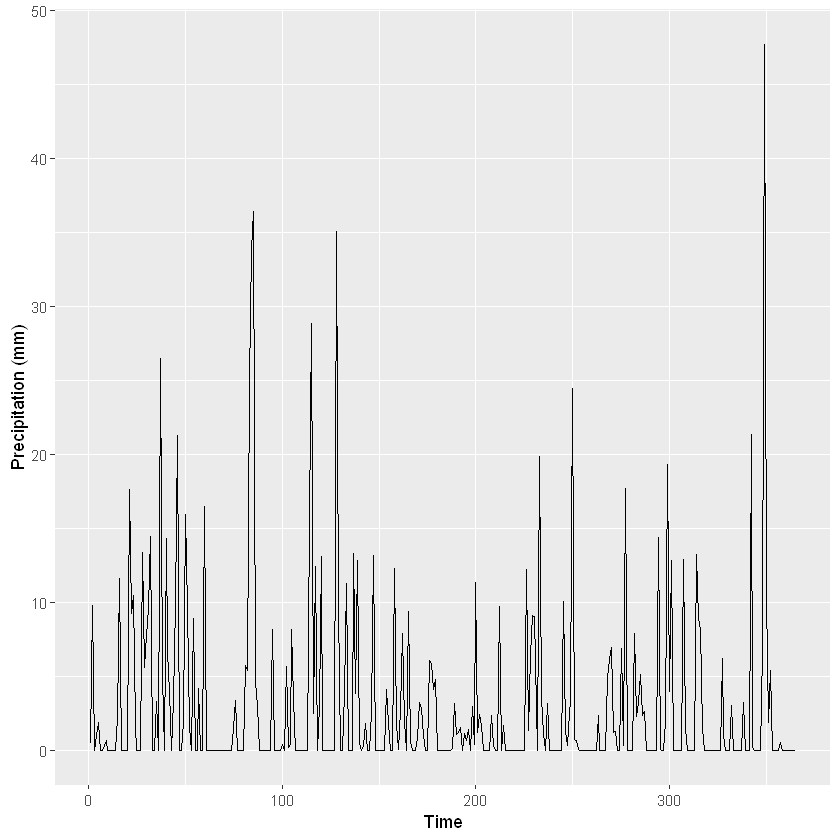

In [16]:
# Simulation based on CMD data
precipCMT <- read.csv("Data/RR_STAID003922.txt", skip = 20, header = T)
precipCMT$RR <-precipCMT$RR / 10

sim <- simulatePrecip(historical = precipCMT$RR,
                      days = 365,
                      distribution = 'gamma')

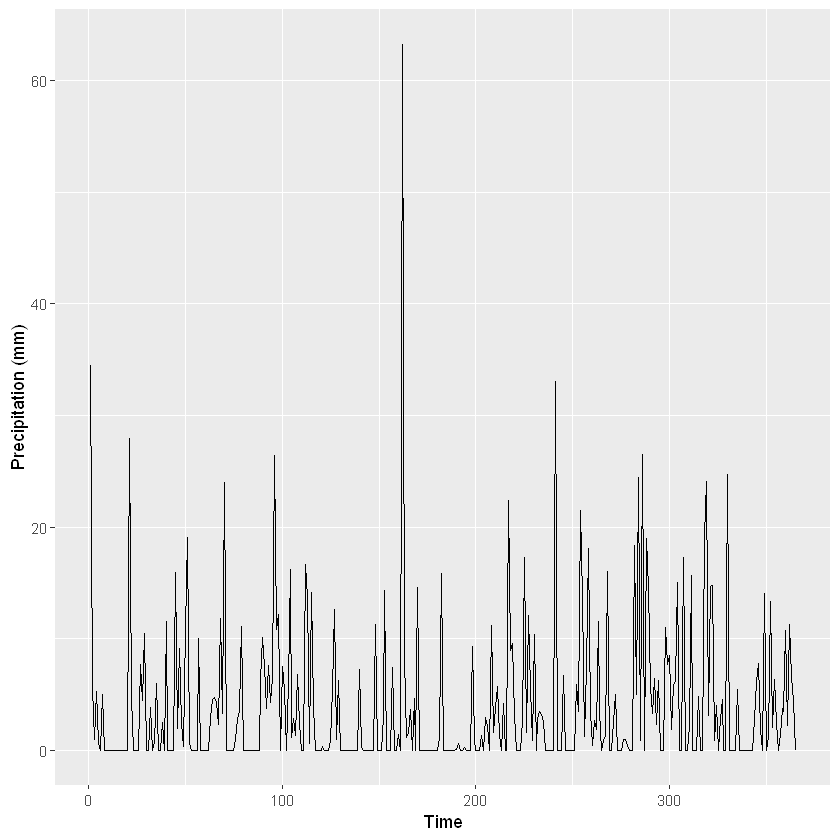

In [17]:
precipParayas <- read.csv("Data/RR_STAID003923.txt", skip = 20, header = T)
precipParayas <- precipParayas[precipParayas$Q_RR != 9, ]
precipParayas$RR <- precipParayas$RR / 10

sim <- simulatePrecip(historical = precipParayas$RR,
                      days = 365,
                      distribution = 'exponential')